In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from IPython.display import clear_output

import os
import sys
sys.path.append("..") 

import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils

In [2]:
## Fetch the dataset

from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/gdrive', force_remount=False)

# Fetch the dataset

RUNNING_ON_COLAB = True

data_path_electrs = '.'
data_path_photons = '.'

# Paths if runninc on colab
if RUNNING_ON_COLAB:
    from google.colab import drive
    drive.flush_and_unmount()
    drive.mount('/gdrive', force_remount=False)

    def_colab_path = '/gdrive/My Drive/Colab Notebooks/CaloGAN/'
    sys.path.append(def_colab_path)

    data_path_electrs = def_colab_path + 'new_data/CaloGAN_e_210000.root.npz'
    data_path_photons = def_colab_path + 'new_data/CaloGAN_gamma_210000.root.npz'
else:
    # Paths if running locally
    data_path_electrs = './new_data/CaloGAN_e_210000.root.npz'
    data_path_photons   = './new_data/dataCaloGAN_gamma_210000_val.root.npz'

# Load data
data_electrs = np.load(data_path_electrs, allow_pickle=False)
data_photons = np.load(data_path_photons, allow_pickle=False)

Mounted at /gdrive
Mounted at /gdrive


In [4]:
#energy   = torch.tensor(data_train['EnergyDeposit'][ind_arr].reshape(-1, 900)).float()
#momentum = torch.tensor(data_train['ParticleMomentum'][ind_arr]).float()
#point    = torch.tensor(data_train['ParticlePoint'][:, :2][ind_arr]).float()
#pdg      = torch.tensor(data_train['ParticlePDG'][ind_arr]).float()

In [5]:
import matplotlib.pyplot as plt
import seaborn
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tck
import numpy as np
import seaborn as sns
from IPython.display import clear_output

from mpl_toolkits.mplot3d.axes3d import get_test_data
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
sns.set()

def plot_coord_distribution(coord_electrons, coord_photons, mom_electrons, mom_photons):
    f, ax = plt.subplots(5, 2, figsize=(10, 20))
    f.tight_layout()

    coord_arr = [coord_electrons, coord_photons]
    mom_arr = [mom_electrons, mom_photons]

    marker_style = {
        'alpha' : 0.5, 
        'marker' : 'o',
        'markersize' : 3,
        'markeredgecolor' : 'black',
        'linestyle' : ''
    }

    coord_lim, mom_xy_lim, mom_z_lim = min_max_values(np.concatenate((coord_electrons, coord_photons), axis=0),
                                                      np.concatenate((mom_electrons, mom_photons), axis=0))

    bin_num = 100
    min_coord, max_coord = -coord_lim, +coord_lim
    min_xy_mom, max_xy_mom = -mom_xy_lim, +mom_xy_lim
    min_z_mom, max_z_mom = -1.0, +mom_z_lim+1.0

    for i, part_name in zip([0, 1], ['electrons', 'photons']):
    # --- coordinates ---

        ax[0,i].set_xlim(min_coord, max_coord)
        ax[0,i].set_ylim(min_coord, max_coord)
        ax[0,i].set_title('Particle coordinates for ' + part_name)
        ax[0,i].set_xlabel('x')
        ax[0,i].set_ylabel('y')
        ax[0,i].set_aspect('equal', 'box')
        ax[0,i].plot(coord_arr[i][:,0], coord_arr[i][:,1], **marker_style, color='royalblue')

        ax[1,i].set_title('Particle coordinates histogram for ' + part_name)
        ax[1,i].set_xlabel('x')
        ax[1,i].set_ylabel('y')
        ax[1,i].set_aspect('equal', 'box')

        ticks_num = 5
        ticks = np.linspace(0, bin_num, ticks_num)
        labels = np.linspace(min_coord, max_coord, ticks_num)

        ax[1,i].set_xlim(-1, bin_num+1)
        ax[1,i].set_ylim(-1, bin_num+1)
        ax[1,i].set_xticks(ticks)
        ax[1,i].set_xticklabels(labels)
        ax[1,i].set_yticks(ticks)
        ax[1,i].set_yticklabels(labels)

        hist, x_edges, y_edges = np.histogram2d(coord_arr[i][:,0], coord_arr[i][:,1], bins=bin_num)
        im = ax[1,i].imshow(hist, origin='lower left')
        divider = make_axes_locatable(ax[1,i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    # --- momentum ---

        ax[2,i].set_xlim(min_xy_mom, max_xy_mom)
        ax[2,i].set_ylim(min_xy_mom, max_xy_mom)
        ax[2,i].set_title('Particle momentum for ' + part_name)
        ax[2,i].set_xlabel(r'$p_x$')
        ax[2,i].set_ylabel(r'$p_y$')
        ax[2,i].set_aspect('equal', 'box')
        ax[2,i].plot(mom_arr[i][:,0], mom_arr[i][:,1], **marker_style, color='springgreen')

        ax[3,i].set_xlim(min_xy_mom, max_xy_mom)
        ax[3,i].set_ylim(min_z_mom, max_z_mom)
        ax[3,i].set_title('Particle momentum for ' + part_name)
        ax[3,i].set_xlabel(r'$p_x$')
        ax[3,i].set_ylabel(r'$p_z$')
        #ax[3,i].set_aspect('equal', 'box')
        ax[3,i].plot(mom_arr[i][:,0], mom_arr[i][:,2], **marker_style, color='springgreen')

        #ax[4,i].set_xlim(min_xy_mom, +12.0)
        ax[4,i].set_ylim(min_z_mom, max_z_mom)
        ax[4,i].set_title('Particle momentum for ' + part_name)
        ax[4,i].set_xlabel(r'$p_{l} (longitudinal)$')
        ax[4,i].set_ylabel(r'$p_{t} (transverse)$')
        #ax[4,i].set_aspect(0.5, 'box')

        long_mom = np.zeros(mom_arr[i].shape[0])

        for j in range(mom_arr[i].shape[0]):
            long_mom[j] = (mom_arr[i][j,0] ** 2 + mom_arr[i][j,1] ** 2) ** 0.5

        ax[4,i].plot(long_mom, mom_arr[i][:,2], **marker_style, color='magenta')
    
    f.subplots_adjust(hspace=0.25)
    plt.show()

def min_max_values(coord_arr, mom_arr):
    min_x = coord_arr[:,0].min()
    max_x = coord_arr[:,0].max()
    min_y = coord_arr[:,1].min()
    max_y = coord_arr[:,1].max()

    print('x ∈ [%f, %f]' % (min_x, max_x))
    print('y ∈ [%f, %f]' % (min_y, max_y))
    print()
    print('p_x ∈ [%f, %f]' % (mom_arr[:,0].min(), mom_arr[:,0].max()))
    print('p_y ∈ [%f, %f]' % (mom_arr[:,1].min(), mom_arr[:,1].max()))
    print('p_z ∈ [%f, %f]' % (mom_arr[:,2].min(), mom_arr[:,2].max()))

    coord_lim  = np.ceil(np.max(np.abs(coord_arr)))
    mom_xy_lim = np.ceil(np.max(np.abs(mom_arr[:,0:1])))
    mom_z_lim  = np.ceil(np.max(np.abs(mom_arr[:,2])))
    return coord_lim, mom_xy_lim, mom_z_lim

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
plot_coord_distribution(data_electrs['ParticlePoint'], 
                        data_photons['ParticlePoint'], 
                        data_electrs['ParticleMomentum'], 
                        data_photons['ParticleMomentum'])

x ∈ [-13.957687, 12.058845]
y ∈ [-13.093182, 12.924507]

p_x ∈ [-54.295932, 52.203500]
p_y ∈ [-53.171500, 52.977843]
p_z ∈ [0.839082, 99.952902]


In [11]:
def plot_log_distributions(coord_electrons, coord_photons, mom_electrons, mom_photons):
    f, ax = plt.subplots(3, 2, figsize=(10, 15))
    f.tight_layout()

    coord_arr = [coord_electrons, coord_photons]
    mom_arr = [mom_electrons, mom_photons]

    marker_style = {
        'alpha' : 0.5, 
        'marker' : 'o',
        'markersize' : 3,
        'markeredgecolor' : 'black',
        'linestyle' : ''
    }

    coord_lim, mom_xy_lim, mom_z_lim = min_max_values(np.concatenate((coord_electrons, coord_photons), axis=0),
                                                      np.concatenate((mom_electrons, mom_photons), axis=0))

    bin_num = 100
    min_coord, max_coord = -coord_lim, +coord_lim
    min_xy_mom, max_xy_mom = -mom_xy_lim, +mom_xy_lim
    min_z_mom, max_z_mom = -1.0, +mom_z_lim+1.0

    for i, part_name in zip([0, 1], ['electrons', 'photons']):
    # --- coordinates ---
        j = 0

        ax[j,i].set_title(r'Particle coordinates $\log_{10}$ histogram for ' + part_name)
        ax[j,i].set_xlabel(r'$x$')
        ax[j,i].set_ylabel(r'$y$')
        ax[j,i].set_aspect('equal', 'box')

        ticks_num = 5
        ticks = np.linspace(0, bin_num, ticks_num)
        labels = np.linspace(min_coord, max_coord, ticks_num)

        ax[j,i].set_xlim(-1, bin_num+1)
        ax[j,i].set_ylim(-1, bin_num+1)
        ax[j,i].set_xticks(ticks)
        ax[j,i].set_xticklabels(labels)
        ax[j,i].set_yticks(ticks)
        ax[j,i].set_yticklabels(labels)

        hist, x_edges, y_edges = np.histogram2d(coord_arr[i][:,0], coord_arr[i][:,1], bins=bin_num)
        im = ax[j,i].imshow(np.log10(hist + 1.0), origin='lower left')
        divider = make_axes_locatable(ax[j,i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        j += 1

    # --- momentum ---

        ax[j,i].set_title(r'Particle moment projections $\log_{10}$ histogram for ' + part_name)
        ax[j,i].set_xlabel(r'$p_x$')
        ax[j,i].set_ylabel(r'$p_y$')
        ax[j,i].set_aspect('equal', 'box')

        ticks_num = 5
        ticks = np.linspace(0, bin_num, ticks_num)
        labels = np.linspace(min_xy_mom, max_xy_mom, ticks_num)

        ax[j,i].set_xlim(-1, bin_num+1)
        ax[j,i].set_ylim(-1, bin_num+1)
        ax[j,i].set_xticks(ticks)
        ax[j,i].set_xticklabels(labels)
        ax[j,i].set_yticks(ticks)
        ax[j,i].set_yticklabels(labels)

        hist, x_edges, y_edges = np.histogram2d(mom_arr[i][:,0], mom_arr[i][:,1], bins=bin_num)
        im = ax[j,i].imshow(np.log10(hist + 1.0), origin='lower left')
        divider = make_axes_locatable(ax[j,i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        j += 1

        ax[j,i].set_title(r'Particle moment projections $\log_{10}$ histogram for ' + part_name)
        ax[j,i].set_xlabel(r'$p_x$')
        ax[j,i].set_ylabel(r'$p_z$')
        ax[j,i].set_aspect('equal', 'box')

        ticks_num = 5
        ticks = np.linspace(0, bin_num, ticks_num)
        xlabels = np.linspace(min_xy_mom, max_xy_mom, ticks_num)
        ylabels = np.linspace(min_z_mom, max_z_mom, ticks_num)

        ax[j,i].set_xlim(-1, bin_num+1)
        ax[j,i].set_ylim(-1, bin_num+1)
        ax[j,i].set_xticks(ticks)
        ax[j,i].set_xticklabels(xlabels)
        ax[j,i].set_yticks(ticks)
        ax[j,i].set_yticklabels(ylabels)

        hist, x_edges, y_edges = np.histogram2d(mom_arr[i][:,2], mom_arr[i][:,0], bins=bin_num)
        im = ax[j,i].imshow(np.log10(hist + 1.0), origin='lower left')
        divider = make_axes_locatable(ax[j,i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        j += 1

    f.subplots_adjust(hspace=0.25)
    plt.show()

x ∈ [-13.957687, 12.058845]
y ∈ [-13.093182, 12.924507]

p_x ∈ [-54.295932, 52.203500]
p_y ∈ [-53.171500, 52.977843]
p_z ∈ [0.839082, 99.952902]


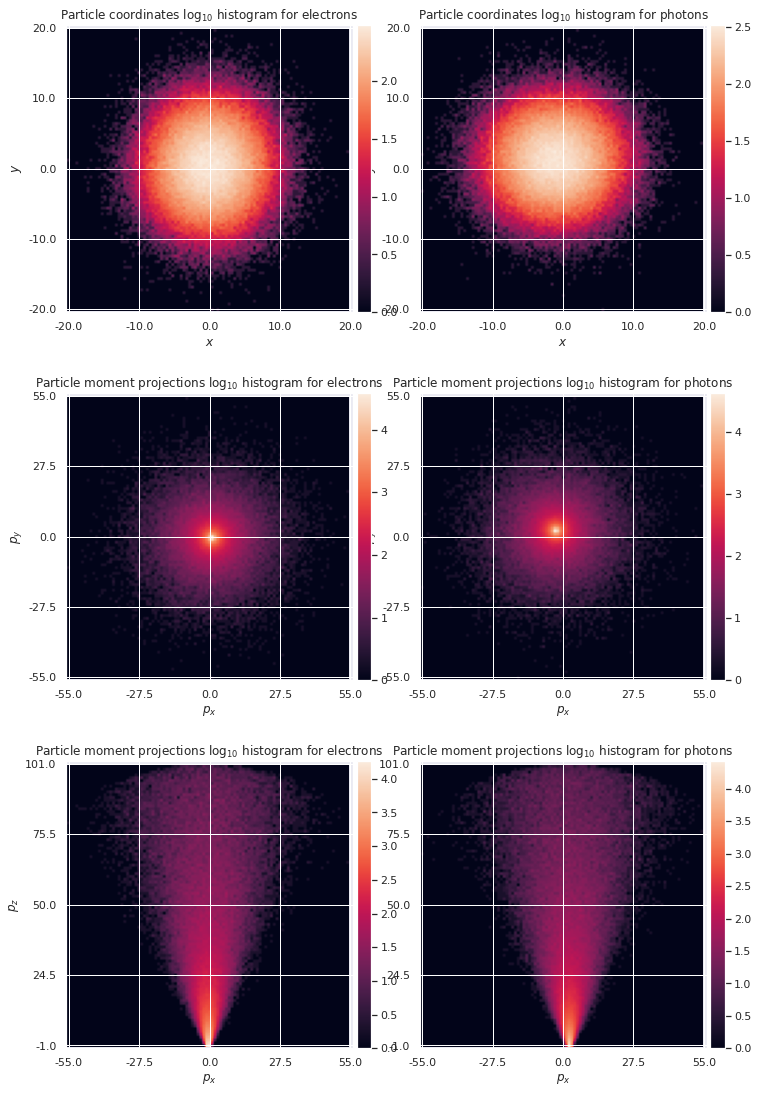

In [12]:
plot_log_distributions(data_electrs['ParticlePoint'], 
                       data_photons['ParticlePoint'], 
                       data_electrs['ParticleMomentum'], 
                       data_photons['ParticleMomentum'])

In [18]:
import matplotlib.cm as cm
import matplotlib
#!pip install mayavi
#from mayavi import mlab     # doesn't install on colab for some reason
#mlab.barchart(xpos,ypos,dz) # ?

def sph2cart(r, theta, phi):
    '''spherical to cartesian transformation.'''
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

def sphview(ax):
    '''returns the camera position for 3D axes in spherical coordinates'''
    r = np.square(np.max([ax.get_xlim(), ax.get_ylim()], 1)).sum()
    theta, phi = np.radians((90-ax.elev, ax.azim))
    return r, theta, phi

def ravzip(*itr):
    '''flatten and zip arrays'''
    return zip(*map(np.ravel, itr))

In [23]:
def plot_momentum_hist(mom_ind_1, mom_ind_2, if_take_log, surface=True, fix_bug=False):
    f = plt.figure(figsize=(14,7), facecolor='white')

    momentum = [data_electrs['ParticleMomentum'], 
                data_photons['ParticleMomentum']]
    
    for i, part_name in zip([0, 1], ['electrons', 'photons']):
        ax = f.add_subplot(1, 2, i+1, projection='3d')
        ax.set_facecolor('white')
        
        ax.set_title('Particle momentum histogram for ' + part_name, fontsize=16)
        
        axes = f.gca(projection='3d')
        axes.zaxis.labelpad=12
        axes.xaxis.labelpad=8
        axes.yaxis.labelpad=8

        ax.xaxis.set_rotate_label(False) 
        ax.yaxis.set_rotate_label(False) 
        ax.zaxis.set_rotate_label(False) 
        
        z_label = r'Number of particles, '

        BINS = 100

        hist, x_edges, y_edges = np.histogram2d(momentum[i][:,mom_ind_1], 
                                                momentum[i][:,mom_ind_2], 
                                                bins=BINS)

        ax.set_xlabel(r'$p_' + str(mom_ind_1) + r'$', fontsize=14)
        ax.set_ylabel(r'$p_' + str(mom_ind_2) + r'$', fontsize=14)

        if if_take_log:
            hist = np.log10(hist + 1.0)
            z_label += r'$\log$'
        else:
            hist /= 1000.0
            z_label += r'$10^3$'
        ax.set_zlabel(z_label, rotation=90)

        X, Y = y_edges[0:-1], x_edges[0:-1]
        X, Y = np.meshgrid(X, Y)

        if surface:
            ax.plot_surface(X, Y, hist, rstride=2, cstride=2,
                            cmap=cm.seismic, linewidth=0.1, edgecolor='black', antialiased=True)
        else:
            # box coordinates and width
            X, Y = np.meshgrid(X, Y)
            xpos, ypos, zpos = X.ravel(), Y.ravel(), 0.0
            bin_width = xpos[1] - xpos[0]
            dx = dy = np.full(xpos.shape, bin_width)
            dz = hist.ravel()

            #color
            offset = dz + np.abs(dz.min())
            fracs = offset.astype(float)/offset.max()
            norm = matplotlib.colors.Normalize(fracs.min(), fracs.max())
            box_colors = cm.jet(norm(fracs))

            if fix_bug:
                # workaround matplotlib's clipping bug 
                # (see https://matplotlib.org/mpl_toolkits/mplot3d/faq.html#my-3d-plot-doesn-t-look-right-at-certain-viewing-angles)
                # (taken from here https://stackoverflow.com/questions/18602660/matplotlib-bar3d-clipping-problems)
                xyz = np.array(sph2cart(*sphview(ax)), ndmin=3).T         # camera position in xyz
                zo = np.multiply([X, Y, np.zeros_like(hist)], xyz).sum(0) # "distance" of bars from camera

                bars = np.empty(X.shape, dtype=object)
                for i, (x,y,dz,o) in enumerate(ravzip(X, Y, hist, zo)):
                    j, k = divmod(i, BINS)
                    bars[j, k] = pl = ax.bar3d(x, y, 0, dx, dy, dz, 
                                            color=box_colors[j * BINS + k], 
                                            linewidth=0.1,
                                            edgecolor='black', alpha=1.0, shade=False)
                    pl._sort_zpos = o
                del bars, zo, xyz
                # workaround end
            else:
                ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=box_colors, 
                        linewidth=0.1, edgecolor='black', alpha=1.0, shade=True)
        
    plt.tight_layout()
    plt.show()

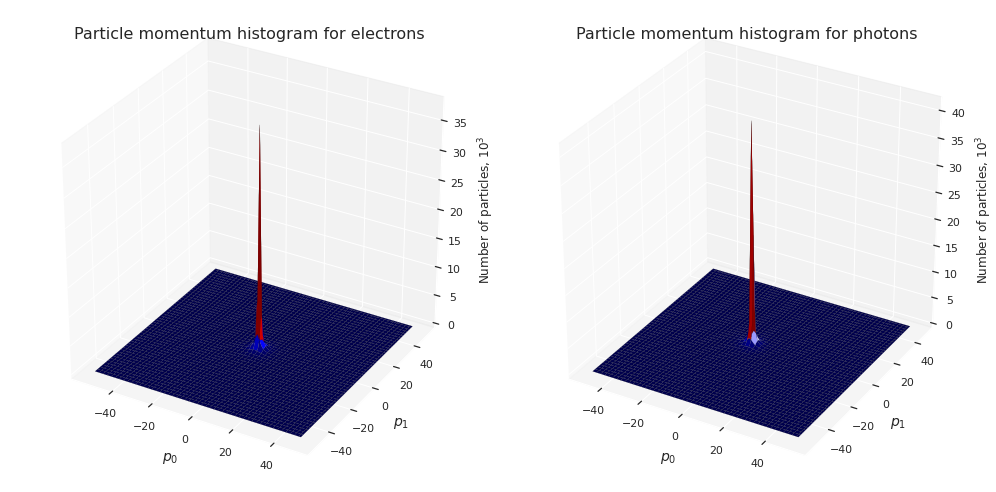

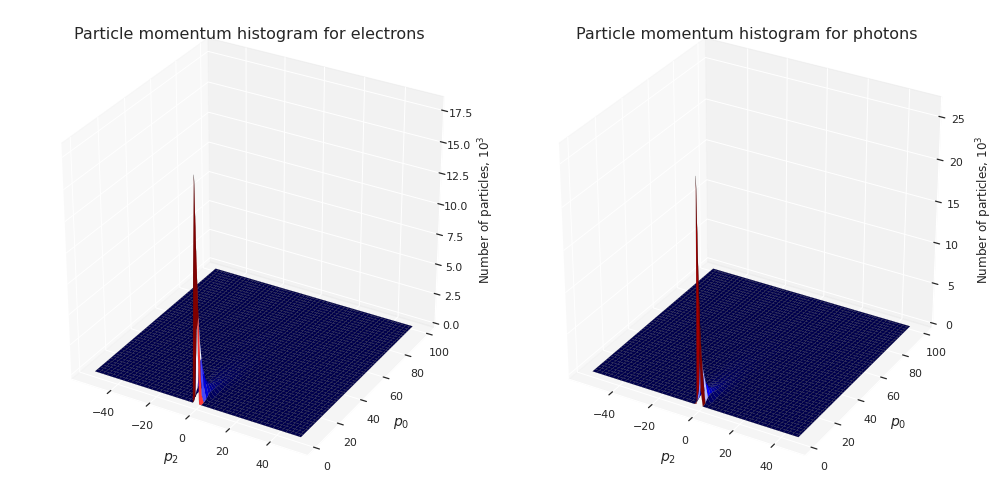

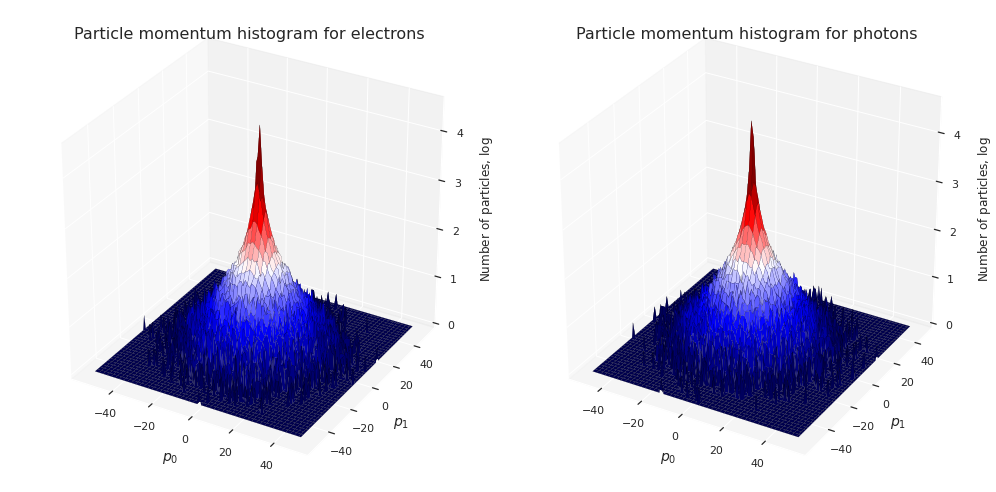

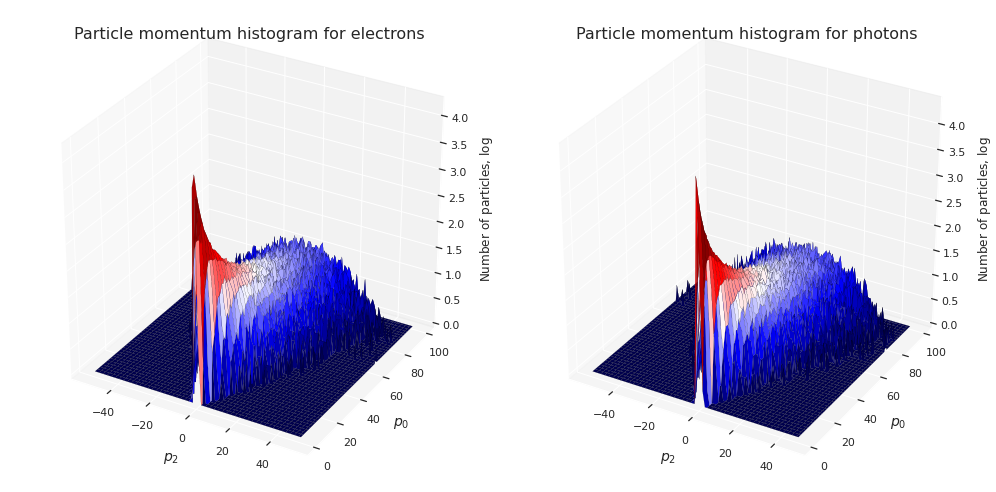

In [24]:
plot_momentum_hist(0, 1, False) # x,y
plot_momentum_hist(2, 0, False) # x,z
plot_momentum_hist(0, 1, True)  # x,y, log
plot_momentum_hist(2, 0, True)  # x,z, log

In [46]:
import scipy

def plot_theor_and_exp_energy(theory_momentum, experiment_energy_distr, 
                              particle_title, x_axis_title):
    exper = np.sum(experiment_energy_distr, axis=1).sum(axis=1)

    kinetic_energy = (theory_momentum[:,0] ** 2 + theory_momentum[:,1] ** 2 + theory_momentum[:,2] ** 2) ** 0.5
    # (np.norm(theory_momentum, p=2, dim=1))
    # * scipy.constants.c * 100.)
    #print(theory_momentum[0])
    #print((theory_momentum[0,0] ** 2 + theory_momentum[0,1] ** 2 + theory_momentum[0,2] ** 2) ** 0.5)
    #print(kinetic_energy[0])
    #print(exper[0])
    #print(energy_electrons[0].sum())
    # for photons 
    mc2 = 0.51099895
    theory = (kinetic_energy)#** 2 + mc2 ** 2) ** 0.5 
    #print("p = ", momentum[0])mean
    #print("|p|_eucl = ", torch.norm(momentum[0], p=2)) # sqrt(px^2 + py^2 +pz^2)
    #print("pc = ", torch.norm(momentum[0], p=2) * scipy.constants.c)
    # get the bin edges to get an equal bin size for both distributions
    #bins = np.histogram(np.hstack((exper, theory)), bins=100)[1]

    #print(theory.min())
    #print(exper.min())

    f, ax = plt.subplots(1,2, figsize=(16, 4))

    ax[0].set_title('Energy from momentum (' + particle_title + ')')
    ax[0].set_xlabel(x_axis_title)
    ax[0].set_ylabel('Number of particles')

    bins = np.histogram(theory, bins=100)[1]
    ax[0].hist(theory, bins, label='Theoretical', color = "blue",  ec="darkblue",  alpha=0.5)
    ax[0].legend()

    ax[1].set_title('Energy from energy distribution (' + particle_title + ')')
    ax[1].set_xlabel(x_axis_title)
    ax[1].set_ylabel('Number of particles')

    bins = np.histogram(exper, bins=100)[1]
    ax[1].hist(exper, bins, label='Experimental', color = "red",  ec="darkred",  alpha=0.5)
    ax[1].legend()

    plt.show()

(210000,)


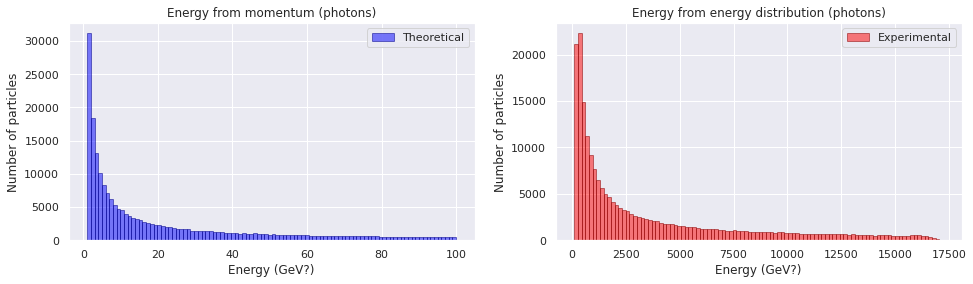

In [48]:
#plot_theor_and_exp_energy(momentum, energy, 'all particles', 'Energy (GeV?)')
#plot_theor_and_exp_energy(momentum_electrons, energy_electrons, 'electrons', 'Energy (GeV?)')

plot_theor_and_exp_energy(data_photons['ParticleMomentum'], 
                          data_photons['EnergyDeposit'], 
                          'photons', 'Energy (GeV?)')

#log

In [49]:
def plot_energy_distribution(energy_electrons, energy_photons):
    f, ax = plt.subplots(4, 2, figsize=(10, 20))
    f.tight_layout()

    energy_distr = [energy_electrons, energy_photons]

    en_dep_vanilla = [energy_distr[0].mean(axis=0).reshape((30,30)), 
                      energy_distr[1].mean(axis=0).reshape((30,30))]

    en_dep_normall = [((energy_distr[0][:].reshape((-1,30,30)) - en_dep_vanilla[0]) 
                        / energy_distr[0].std(axis=0).reshape((30,30))).mean(axis=0).reshape((30,30)) * 10e6,
                        ((energy_distr[1][:].reshape((-1,30,30)) - en_dep_vanilla[1]) 
                        / energy_distr[1].std(axis=0).reshape((30,30))).mean(axis=0).reshape((30,30)) * 10e6]

    end_dep_transf = [(1.0 - 1.0 / (1.0 + energy_distr[0][:])).reshape((-1,30,30)).mean(axis=0), 
                      (1.0 - 1.0 / (1.0 + energy_distr[1][:])).reshape((-1,30,30)).mean(axis=0)]
   
    end_dep_logged = [(np.log(1.0 + energy_distr[0][:])).reshape((-1,30,30)).mean(axis=0), 
                      (np.log(1.0 + energy_distr[1][:])).reshape((-1,30,30)).mean(axis=0)]

    for i, part_name in zip([0, 1], ['electrons', 'photons']):
        for j, en_dep, name in zip(range(0,4), 
                                   [en_dep_vanilla[i], en_dep_normall[i], end_dep_transf[i], end_dep_logged[i]], 
                                   ['vanilla', r'normalised: $(1-\mu E)/sE \cdot 10^6$', 
                                    r'transformed: $1-1/(E+1)$', 'logarithmed: \log(1+E)']):
            ax[j,i].set_aspect('equal', 'box')
            ax[j,i].set_title ('Mean energy distribution\n(' + name + ') for ' + part_name,  fontsize=14)
            ax[j,i].set_xlabel(r'$x$', fontsize=12)
            ax[j,i].set_ylabel(r'$y$', fontsize=12)

            ax[j,i].set_xticks(np.arange(-0.5, 30., 1.), minor=True)
            ax[j,i].set_xticks(np.arange(-0.5, 30., 5.), minor=False)                    
            ax[j,i].set_xticklabels(np.arange(-15, 16, 5), minor=False, fontsize=8)

            ax[j,i].set_yticks(np.arange(-0.5, 30., 1.), minor=True)
            ax[j,i].set_yticks(np.arange(-0.5, 30., 5.), minor=False)                    
            ax[j,i].set_yticklabels(np.arange(-15, 16, 5), minor=False, fontsize=8)

            ax[j,i].grid(which='both', color='dimgray', linestyle='-', linewidth=0.5)
            im = ax[j,i].imshow(en_dep, origin = 'lower', cmap="inferno")
                                #vmin=vmin, vmax=vmax)

            divider = make_axes_locatable(ax[j,i])
            cax = divider.append_axes("right", size="4%", pad=0.05)
            plt.colorbar(im, cax=cax)
    
    f.subplots_adjust(hspace=0.35)
    plt.show()

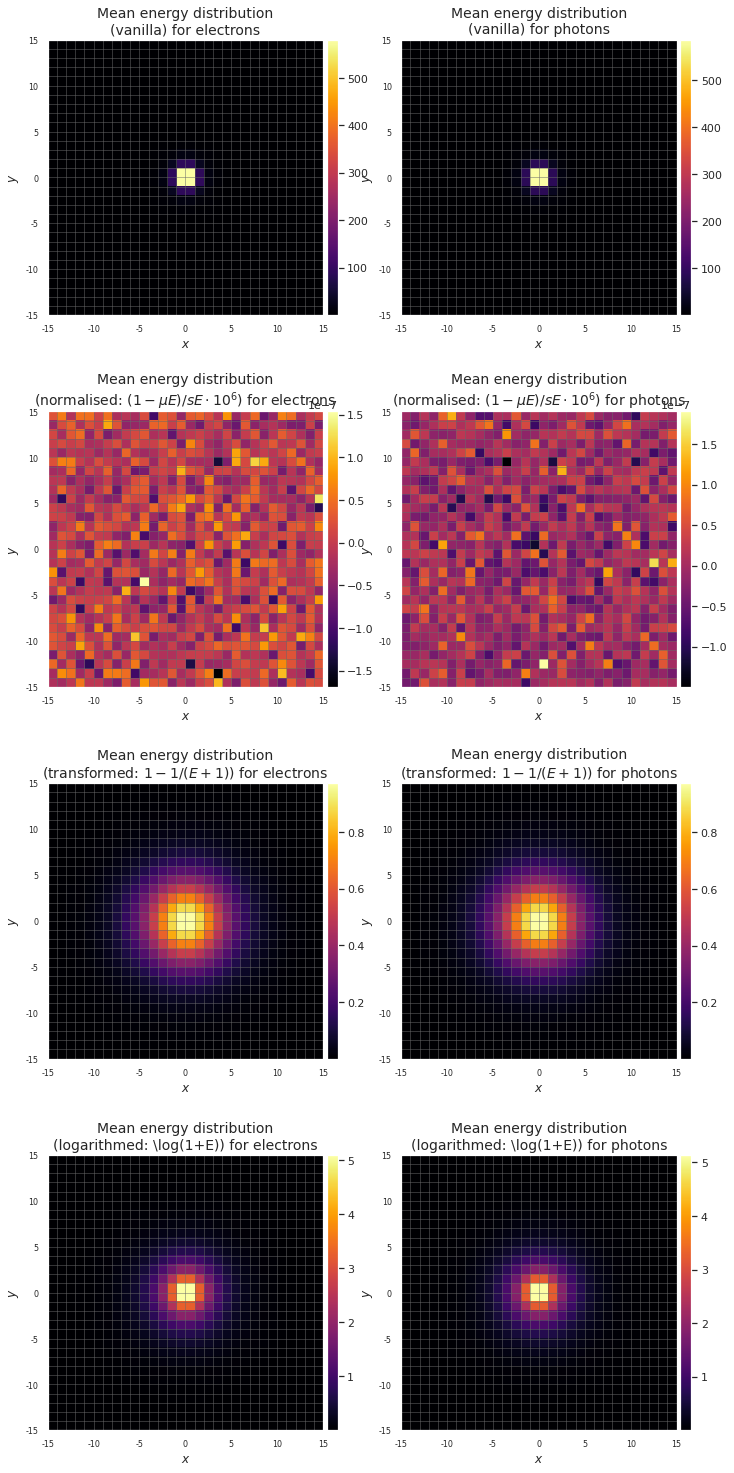

In [50]:
plot_energy_distribution(data_electrs['EnergyDeposit'], 
                         data_photons['EnergyDeposit'])